In [1]:
import torch
import torch.linalg as tla
import numpy as np
import matplotlib.pyplot as plt
import numml.sparse as sp

In [2]:
# Create our favorite poisson operator

N = 16
A = sp.eye(N)*2. - sp.eye(N, k=1) - sp.eye(N, k=-1)
print(A.to_dense())

tensor([[ 2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [-1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.,
          0.,  0.],
        [ 

In [3]:
# A row-wise weighted jacobi, where instead of a scalar omega we have an n-length vector
# weighting each entry

def node_weighted_jacobi(A, x, b, omega):
    Dinv = sp.diag(1./A.diagonal())
    return omega * (Dinv @ b) + (sp.eye(A.shape[0]) - sp.diag(omega) @ (Dinv@A)) @ x

In [4]:
# We'll optimize over the best weight for each entry

b = torch.zeros(N)
omega = torch.ones(N, requires_grad=True)

In [5]:
optimizer = torch.optim.Adam([omega], lr=1e-2)
batch = 20
lh = []
oh = []
jac_iter = 1

for i in range(100):
    optimizer.zero_grad()
    
    loss = 0.
    
    for j in range(batch):
        x = torch.rand(N)
        x /= tla.norm(x)
        for k in range(jac_iter):
            x = node_weighted_jacobi(A, torch.rand(N), b, omega)
        loss += torch.sum((b - A @ x)**2.) / batch
    
    loss.backward()
    
    optimizer.step()
    
    lh.append(loss.item())
    oh.append(omega.detach().numpy().copy())
    if i % 10 == 0:
        print(i, 'loss:', round(loss.item(), 3), 'omega:', torch.round(omega.detach(), decimals=2))

0 loss: 4.429 omega: tensor([0.9900, 0.9900, 0.9900, 0.9900, 0.9900, 0.9900, 0.9900, 0.9900, 0.9900,
        0.9900, 0.9900, 0.9900, 0.9900, 0.9900, 0.9900, 0.9900])
10 loss: 3.52 omega: tensor([0.8900, 0.8900, 0.8900, 0.8900, 0.9000, 0.9000, 0.8900, 0.8900, 0.8900,
        0.8900, 0.9000, 0.9000, 0.9000, 0.9000, 0.8900, 0.8900])
20 loss: 1.893 omega: tensor([0.8100, 0.8000, 0.8100, 0.8000, 0.8100, 0.8100, 0.8000, 0.8000, 0.8100,
        0.8100, 0.8100, 0.8100, 0.8100, 0.8100, 0.8100, 0.8100])
30 loss: 1.193 omega: tensor([0.7400, 0.7300, 0.7300, 0.7300, 0.7300, 0.7300, 0.7200, 0.7200, 0.7300,
        0.7300, 0.7300, 0.7300, 0.7400, 0.7400, 0.7300, 0.7500])
40 loss: 0.672 omega: tensor([0.7100, 0.6600, 0.6600, 0.6600, 0.6600, 0.6700, 0.6600, 0.6500, 0.6700,
        0.6700, 0.6700, 0.6700, 0.6800, 0.6800, 0.6700, 0.7200])
50 loss: 0.612 omega: tensor([0.6900, 0.6100, 0.6100, 0.6100, 0.6100, 0.6200, 0.6100, 0.6100, 0.6200,
        0.6200, 0.6300, 0.6300, 0.6300, 0.6300, 0.6200, 0.7000])


Text(0, 0.5, 'Jacobi Weight')

<Figure size 600x500 with 0 Axes>

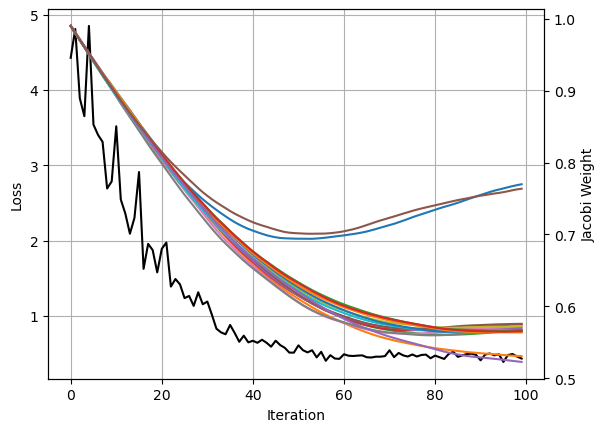

In [19]:
Lh = np.array(lh)
Oh = np.array(oh)

plt.figure(figsize=(6, 5))

plt.figure()
plt.plot(Lh, 'k')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()

ax2 = plt.gca().twinx()
ax2.plot(Oh)
ax2.set_ylabel('Jacobi Weight')

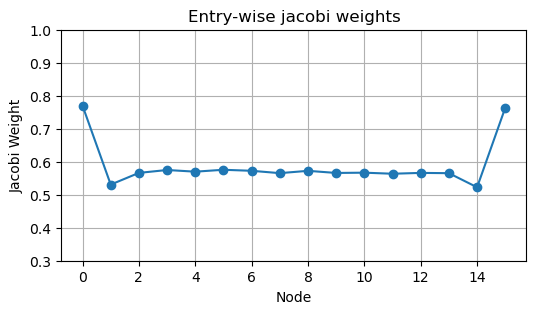

In [16]:
plt.figure(figsize=(6, 3))
plt.title('Entry-wise jacobi weights')
plt.plot(omega.detach(), 'o-')
plt.ylim(0.3, 1)
plt.xlabel('Node')
plt.ylabel('Jacobi Weight')
plt.grid()